# 多重スリットにおける回折・干渉実験の光の強度分布(2次元版)　
## スリットの座標のデータフレーム作成

### 必要なライブラリのインポート

In [1]:
#%matplotlib notebook
import numpy as np
import cmath
import numba
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib.ticker import LinearLocator
import datetime
import pytz

### 各種設定

In [2]:
# スリットースクリーン間距離
L = 1.0*10**3
# 光の波長
lam = 4.0*10**(-4)
# スクリーンの初期位置
x_0 = 10.0
# x軸方向のスリット間距離
dx = 0.1
# y軸方向のスリット幅
dy = 0.1
# 波数
k = (2*np.pi)/lam
# スリット数(奇数限定)
N = 5
n = (N-1)*0.5
# スリット幅の配列
slit_number = np.arange(-n, n+1)
# 回転角
theta = 0
# スクリーン上の各点との距離を格納するリストの用

### 回転行列の定義

In [3]:
# https://snowtree-injune.com/2021/02/14/rotation-ana009/#toc6
rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                            [np.sin(theta), np.cos(theta)]])

### numpy.meshgrid()を利用するための格子点の設定(スクリーン上のX,Y座標の設定)

In [4]:
# 格子の分割数
m = 2**8 + 1
# スクリーンのx,y座標の設定
X,Y = np.meshgrid(np.linspace(-x_0, x_0, m), np.linspace(-x_0, x_0, m))
# 強度分布格納用配列の初期化
I_points = np.zeros([m, m])

### スリットの座標のデータフレームの作成

In [5]:
df_slit_data = pd.DataFrame(
    data = {'x': slit_number*dx, #x座標の指定
            'y': dy*np.ones(N)} #y座標の指定
)

In [6]:
# インデックスをスリット番号に変更
df_slit_data.index = slit_number

In [7]:
# 作成したデータフレームの確認
df_slit_data

,x,y
-2.0,-0.2,0.1
-1.0,-0.1,0.1
0.0,0.0,0.1
1.0,0.1,0.1
2.0,0.2,0.1


### 座標を反時計回りを正としてθ[rad]だけ回転

In [8]:
# 作成したデータフレームの確認
arr_data = df_slit_data.values
# 配列を転置
array_T = arr_data.T

In [9]:
array_T

array([[-0.2, -0.1,  0. ,  0.1,  0.2],
       [ 0.1,  0.1,  0.1,  0.1,  0.1]])

In [10]:
# 行列積の計算
new_data = rotation_matrix@array_T

In [11]:
new_data

array([[-0.2, -0.1,  0. ,  0.1,  0.2],
       [ 0.1,  0.1,  0.1,  0.1,  0.1]])

### 座標をリスト型に変換

In [12]:
# https://note.nkmk.me/python-pandas-numpy-conversion/
slit_coordinate_x = list(new_data[0])
slit_coordinate_y = list(new_data[1])

slit_count = len(slit_coordinate_x)

### 各スリットからスクリーン上の点までの距離の計算

$$
R = \sqrt{L^2+(X-x)^2+(Y-y)^2}
$$

In [13]:
R_points = np.array([np.sqrt(
    (X-slit_coordinate_x[i])**2 + (Y-slit_coordinate_y[i])**2)
                     for i in range(slit_count)])

### 波の重ね合わせ（繰り返し処理）

In [14]:
@numba.jit
def calc_I(N, m, k, R_points, I_points):
    for s in range(m):
        count = 0
        for t in range(m):
            # 電場の初期化
            E = 0
            for u in range(N):
                # 電場の計算
                E += cmath.exp(1j*k*R_points[u, s, t])
            # 光強度の計算結果を格納
            I_points[s, count] = np.abs(E)**2
            count += 1

In [15]:
calc_I(N, m, k, R_points, I_points)

### 光の強度分布，干渉縞のグラフ化

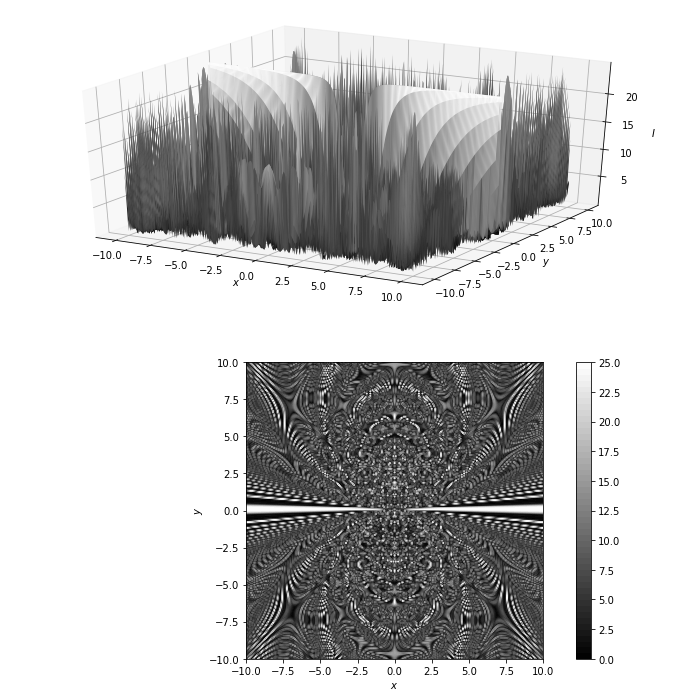

In [16]:
# https://learntutorials.net/ja/matplotlib/topic/3385/%E3%82%AB%E3%83%A9%E3%83%BC%E3%83%9E%E3%83%83%E3%83%97
fig = plt.figure(
    figsize = (12, 12),
    facecolor = "white",
    edgecolor = "black",
)

ax1 = fig.add_subplot(211, projection='3d')
ax1.plot_surface(X, Y, I_points, rstride=1, cstride=1, cmap='gist_gray')

ax2 = fig.add_subplot(212)
# ３次元の等高線を書く
# https://matplotlib.org/2.0.2/examples/color/colormaps_reference.html
# http://taustation.com/matplotlib-pyplot-contour-contourf/#i-3
cf = ax2.contourf(X, Y, I_points, 51, vmin=I_points.min(), vmax=I_points.max(), cmap='gist_gray')
cbar = fig.colorbar(cf)
# 
cbar.locator = LinearLocator(numticks = 11)
cbar.update_ticks()

for ax in {ax1, ax2}:
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')

ax1.set_zlabel(r'$I$')
ax2.set_aspect('equal')

In [17]:
# グラフの保存
time = datetime.datetime.now(pytz.timezone('Asia/Tokyo'))
#(年、月、日付、時、分、秒、マイクロ秒)

#見やすい形に変換
time = time.strftime('%m%d_2D_varsion3.png')
# 図の保存
fig.savefig(time, facecolor = fig.get_facecolor())